This is a course project for dataquest.io course SQL for Intermediate SQL For Data Analysis.

The 'chinook.db' database was provided by the course.
We are exploring and analyzin the database through different SQL methods and running them in Python using sqlite3 module.

Database schema: https://s3.amazonaws.com/dq-content/280/chinook-schema.svg

In [10]:
import sqlite3, pandas as pd


def run_query(q):
"""
Running an SQL query
Parameter: SQL query string
Return value: SQL query result
"""
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(command):
"""
Running an SQL command
Parameter: SQL command
"""
    with sqlite3.connect('chinook.db') as conn:
        cursor = conn.cursor()
        cursor.execute(command)

def show_tables():
"""
Showing database tables
"""
    print(run_query("SELECT * FROM sqlite_master WHERE type='table' OR type='view';"))
    
    

In [11]:
show_tables()

     type            name        tbl_name  rootpage  \
0   table           album           album         2   
1   table          artist          artist         3   
2   table        customer        customer         4   
3   table        employee        employee         5   
4   table           genre           genre         6   
5   table         invoice         invoice         7   
6   table    invoice_line    invoice_line         8   
7   table      media_type      media_type         9   
8   table        playlist        playlist        10   
9   table  playlist_track  playlist_track        11   
10  table           track           track        13   
11   view     top_5_names     top_5_names         0   

                                                  sql  
0   CREATE TABLE [album]\n(\n    [album_id] INTEGE...  
1   CREATE TABLE [artist]\n(\n    [artist_id] INTE...  
2   CREATE TABLE [customer]\n(\n    [customer_id] ...  
3   CREATE TABLE [employee]\n(\n    [employee_id] ...  
4   

In [12]:
# Genre sales in USA

q = '''
SELECT g.name AS genre, SUM(il.quantity) AS tracks_sold, 
    SUM(il.quantity)/CAST((
                    SELECT SUM(quantity) 
                    FROM invoice_line AS il 
                    INNER JOIN invoice AS i ON il.invoice_line_id = i.invoice_id 
                    WHERE i.billing_country = 'USA') AS float)*100 
    AS percentage 
FROM track AS t
LEFT JOIN genre AS g ON t.genre_id = g.genre_id 
LEFT JOIN invoice_line AS il ON t.track_id = il.track_id 
LEFT JOIN invoice as i ON il.invoice_line_id = i.invoice_id 
WHERE i.billing_country = 'USA' 
GROUP BY t.genre_id 
ORDER BY tracks_sold DESC;'''
pandas = run_query(q)
print(pandas)

                 genre  tracks_sold  percentage
0                 Rock           88   67.175573
1   Alternative & Punk           10    7.633588
2                Metal            8    6.106870
3             R&B/Soul            6    4.580153
4            Classical            4    3.053435
5                 Jazz            3    2.290076
6                Latin            2    1.526718
7                  Pop            2    1.526718
8    Electronica/Dance            2    1.526718
9          Alternative            2    1.526718
10               Blues            1    0.763359
11              Reggae            1    0.763359
12      Easy Listening            1    0.763359
13               Drama            1    0.763359


In [31]:
# Dropping top_5_names view

c = '''
DROP VIEW top_5_names
'''
run_command(c)
# Creating top 5 customer names view
c = '''
CREATE VIEW top_5_names AS
     SELECT
         first_name,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
     LIMIT 5;
'''
run_command(c)

In [14]:
# Top 5 customer names
q = 'SELECT * FROM top_5_names;'
run_query(q)

,first_name,count
0,Frank,2
1,Mark,2
2,Aaron,1
3,Alexandre,1
4,Astrid,1


In [29]:
# Dropping country_view

c = '''
DROP VIEW country_customers
'''
run_command(c)

# Creating country view
c = '''
CREATE VIEW country_customers AS
     SELECT
         c.country,
         COUNT(c.customer_id) customers,
         SUM(i.total
         
     FROM customer AS c
     LEFT JOIN invoice AS i ON c.customer_id = i.customer_id
     GROUP by c.country
     ORDER by c.count DESC;
'''
run_command(c)

In [22]:
# Sales by country
# Countries having 1 customer combined to "Other"
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


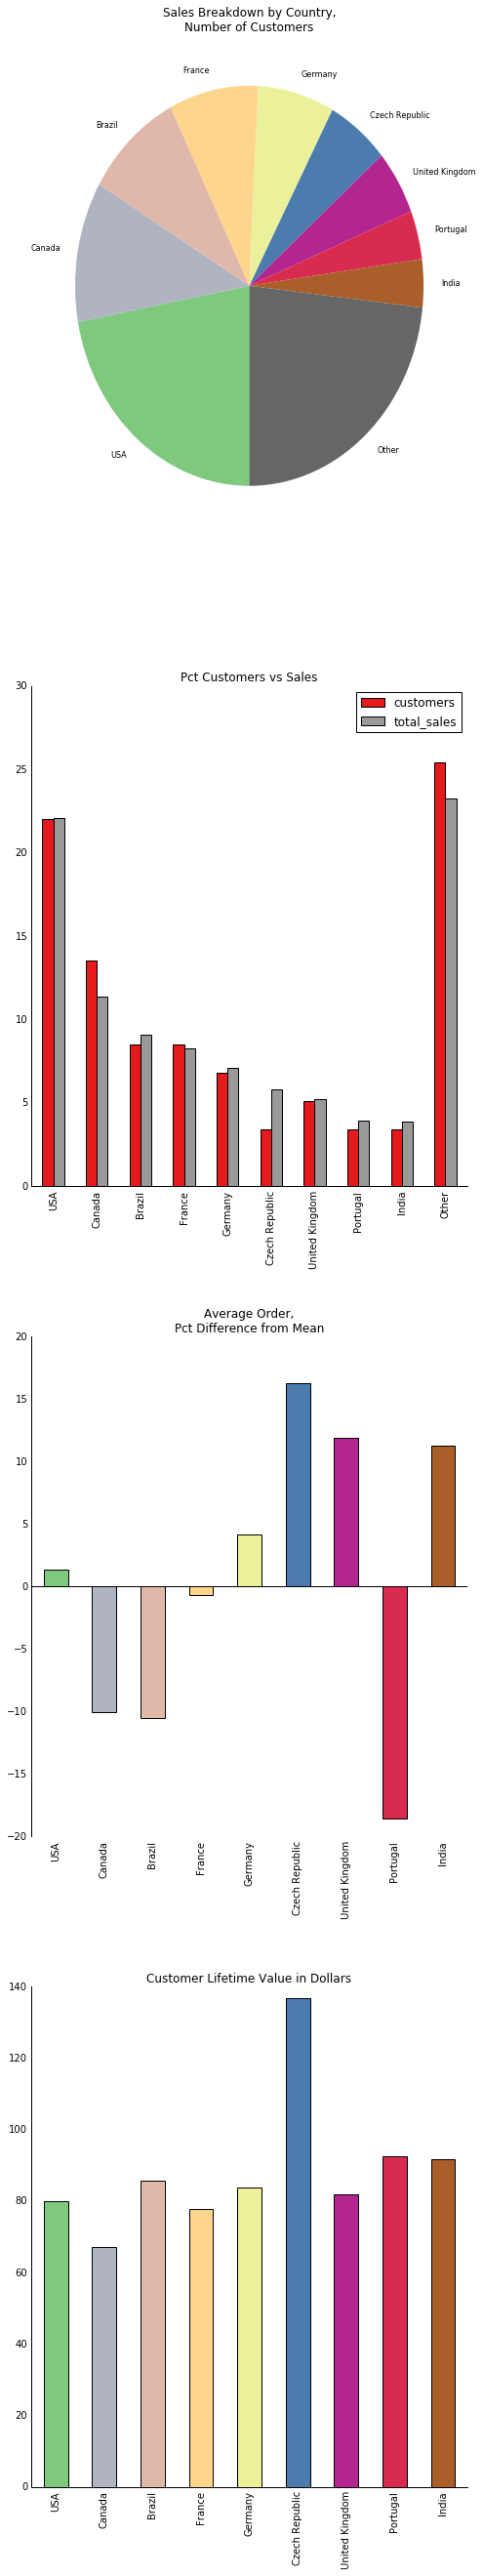

In [53]:
# Visualizing sales by country for analysis purposes

country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 45))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.3)


# Pie chart, total sales by country
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# Bar chart, percentage share of customers and sales
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# Bar chart, average order percents from mean value
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# Bar chart, customer liferime value in dollars
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value in Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()